In [1]:
# =========================================
# STEP 1: Install & Import
# =========================================
!pip install tensorflow pillow google-generativeai --quiet
!pip install faiss-cpu sentence-transformers --quiet

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import google.generativeai as genai

# =========================================
# STEP 2: Upload & Load Model
# =========================================
print("📦 Upload your trained skin disease model (.h5 file):")
uploaded_model = files.upload()
model_file = list(uploaded_model.keys())[0]

model = load_model(model_file)
print(f"✅ Model '{model_file}' loaded successfully!")

# Diagnose model structure
print("\n--- Model Diagnosis ---")
print(f"Model type: {type(model)}")
print("-----------------------\n")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 26.6 MB/s eta 0:00:00
📦 Upload your trained skin disease model (.h5 file):


Saving skin_disease_model.h5 to skin_disease_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model 'skin_disease_model.h5' loaded successfully!

--- Model Diagnosis ---
Model type: <class 'keras.src.models.sequential.Sequential'>
-----------------------



🖼️ Upload a skin image to test:


Saving 19_FU-ringworm (68).jpg to 19_FU-ringworm (68) (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

🔍 Top 3 Predictions:
Ringworm: 87.35%
Shingles: 12.59%
Impetigo: 0.05%


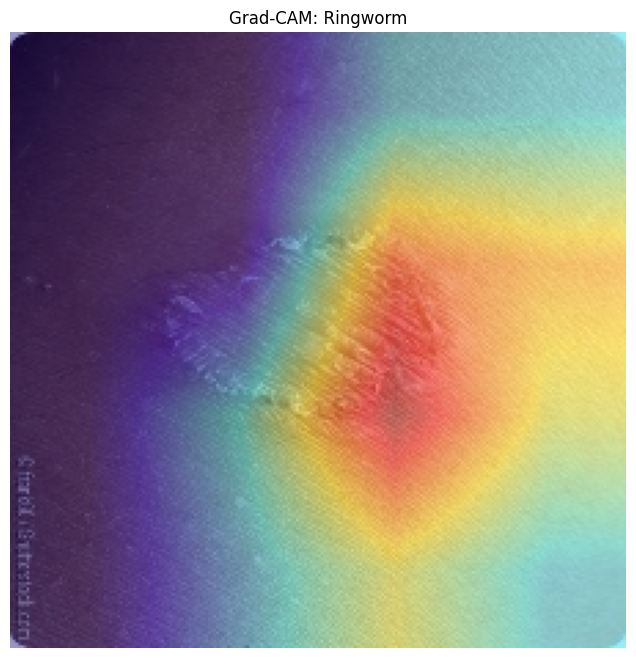

✅ Grad-CAM generated.

📄 Upload your master RAG reference file (e.g. diseases.txt)


Saving skin_diseases.txt to skin_diseases (5).txt
✅ 8 diseases indexed for RAG retrieval.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 RAG Information for Top 3 Predicted Diseases:

### 🩺 1. Ringworm
Ringworm (Tinea Corporis)
• Overview: Superficial fungal infection with ring-shaped, scaly red patches and clear center
Highly contagious; spreads via contact or contaminated items
Causes and Risk
• Factors: Contact with infected people/animals
Sharing towels/clothing
Warm, humid environments
Immunosuppression
Symptoms and Clinical
• Presentation: Ring-shaped red scaly patches with clear center
Itching, discomfort
Lesions may spread
Raised, well-defined borders
• Diagnosis: Clinical exam; skin scrapings/culture
Treatment and
• Medications: Topical antifungals (clotrimazole, terbinafine)
Oral antifungals for resistant cases
Keep affected area clean and dry
Home Care and
• Prevention: Avoid sharing personal items
Wash clothes and bedding
Disinfect surfaces
Maintain hygiene
• Sources: Mayoclinic


### 🩺 2. Shingles
Shingles (Herpes Zoster)
• Overview: Reactivation of varicella-zoster virus
Painful blistering rash along a 

In [9]:
# ============================================================
# 🧠 AI SKIN DISEASE DIAGNOSIS — CNN + GRAD-CAM + RAG + GEMINI Q&A
# ============================================================

# =========================================
# STEP 3: Define Classes
# =========================================
class_names = [
    "Cellulitis", "Impetigo", "Athlete-Foot", "Nail-Fungus",
    "Ringworm", "Cutaneous-larva-migrans", "Chickenpox", "Shingles"
]

# =========================================
# STEP 4: Image Preprocessing
# =========================================
def preprocess_image(img, target_size=(150,150)):
    img = img.resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# =========================================
# STEP 5: Upload Image for Prediction
# =========================================
print("🖼️ Upload a skin image to test:")
uploaded_image = files.upload()
image_file = list(uploaded_image.keys())[0]
image = Image.open(image_file)
image_array = preprocess_image(image)

# =========================================
# STEP 6: CNN Prediction
# =========================================
prediction = model.predict(image_array)[0]
top3_indices = prediction.argsort()[-3:][::-1]
top3_classes = [class_names[i] for i in top3_indices]
top3_probs = [prediction[i] for i in top3_indices]

print("\n🔍 Top 3 Predictions:")
for cls, prob in zip(top3_classes, top3_probs):
    print(f"{cls}: {prob*100:.2f}%")

# =========================================
# STEP 7: Grad-CAM
# =========================================
def find_last_conv_layer_index(model):
    for i in reversed(range(len(model.layers))):
        layer = model.layers[i]
        if isinstance(layer, tf.keras.layers.Conv2D):
            return i
    return None

def make_gradcam_heatmap(img_array, model, last_conv_layer_index, pred_index=None):
    last_conv_layer = model.layers[last_conv_layer_index]
    input_tensor = tf.keras.Input(shape=model.input_shape[1:])
    x = input_tensor
    conv_output = None
    for i, layer in enumerate(model.layers):
        x = layer(x)
        if i == last_conv_layer_index:
            conv_output = x
    final_output = x
    grad_model = Model(inputs=input_tensor, outputs=[conv_output, final_output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

last_conv_layer_index = find_last_conv_layer_index(model)
if last_conv_layer_index is None:
    raise ValueError("❌ No Conv2D layer found in the model for Grad-CAM.")

heatmap = make_gradcam_heatmap(image_array, model, last_conv_layer_index)
gradcam_result = overlay_heatmap(image_file, heatmap)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(gradcam_result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Grad-CAM: {top3_classes[0]}")
plt.show()
print("✅ Grad-CAM generated.")

# =========================================
# STEP 8: RAG Integration
# =========================================
from sentence_transformers import SentenceTransformer
import faiss, re, numpy as np

print("\n📄 Upload your master RAG reference file (e.g. diseases.txt)")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
with open(filename, 'r', encoding='utf-8') as f:
    raw_text = f.read()

disease_sections = re.split(r'\n(?=\d+\.\s)', raw_text.strip())
rag_data = {}
for section in disease_sections:
    match = re.match(r'(\d+)\.\s*([A-Za-z\s’\'\-()]+)', section)
    if match:
        disease_name = match.group(2).strip()
        cleaned_text = re.sub(r'^\d+\.\s*', '', section).strip()
        rag_data[disease_name.lower()] = cleaned_text

print(f"✅ {len(rag_data)} diseases indexed for RAG retrieval.")

embedder = SentenceTransformer('all-MiniLM-L6-v2')
disease_names = list(rag_data.keys())
embeddings = embedder.encode([rag_data[d] for d in disease_names], show_progress_bar=True)

dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

def retrieve_rag_info(query, top_k=1):
    query_vec = embedder.encode([query])
    D, I = index.search(np.array(query_vec), top_k)
    disease_text = rag_data[disease_names[I[0][0]]]
    return disease_text

def format_rag_output(text):
    text = re.sub(r'\n+', '\n', text.strip())
    text = re.sub(r'(?<=:)\s*', ' ', text)
    text = re.sub(r'([A-Z][a-z]+:)', r'\n• \1', text)
    lines = [l.strip() for l in text.split('\n') if l.strip()]
    return "\n".join(lines)

rag_results = []
rag_answer = ""
for i, disease in enumerate(top3_classes):
    query = f"{disease} skin disease overview and treatment"
    result = retrieve_rag_info(query)
    formatted = format_rag_output(result)
    heading = f"### 🩺 {i+1}. {disease.title()}"
    rag_results.append(f"{heading}\n{formatted}\n")
    if i == 0:
        rag_answer = formatted

rag_final_output = "\n\n".join(rag_results)
print("\n📌 RAG Information for Top 3 Predicted Diseases:\n")
print(rag_final_output)

# =========================================
# =========================================
# STEP 9 (ALL QUESTIONS TOGETHER, ONE SINGLE ANSWER)
# =========================================

print("\n🤖 Gemini Nurse: Generating diagnostic questions...\n")

context_prompt = """
You are an AI nurse assessing a possible skin or wound condition.

Generate 4–6 short, patient-friendly diagnostic QUESTIONS that help identify and differentiate between common skin issues (cuts, infections, fungal, allergic, etc.).

Focus on:
- Pain, itching, or burning
- Discharge, pus, or bleeding
- Redness, swelling, or spreading
- Duration or recent cause
- Any fever or systemic symptoms

Output only the numbered questions like this:
1. <question>
2. <question>
3. <question>
"""

nurse_questions = gemini.generate_content(context_prompt).text
print("🧾 Nurse Questions:\n")
print(nurse_questions)

# =========================================
# STEP 9B: Collect ONE combined patient answer
# =========================================
print("\n💬 Please answer all the above questions in one response (describe your condition):\n")
combined_answer = input("👤 Patient: ")

# =========================================
# STEP 9C: Nurse interprets the combined response
# =========================================
interpret_prompt = f"""
You are a clinical nurse summarizing a patient's single detailed response to diagnostic skin questions.

The questions were:
{nurse_questions}

The patient's single combined response was:
"{combined_answer}"

Summarize briefly (3–4 lines):
- What symptoms are described
- How severe it appears (mild, moderate, severe)
- Whether signs of infection or inflammation are present
"""

nurse_summary = gemini.generate_content(interpret_prompt).text
print("\n🩹 Nurse Summary:\n")
print(nurse_summary)

# =========================================
# STEP 10: FINAL DOCTOR REPORT — CNN + RAG + NURSE SUMMARY
# =========================================
final_prompt = f"""
You are an AI clinical assistant generating a structured dermatology report.

Inputs:
- CNN Top 3 Predictions: {top3_classes} with probabilities {top3_probs}
- Grad-CAM confirms affected region.
- RAG medical summary: {rag_answer}
- Nurse interpretation: {nurse_summary}
- Patient combined response: "{combined_answer}"

Write a clear, professional structured report:

1. 🧾 Most Likely Diagnosis — based on CNN + symptoms.
2. 🧠 Clinical Reasoning — explain correlation between image, RAG info, and patient's description.
3. 💊 Recommended Action Tier — self-care, OTC, or referral.
4. 🔴 Red Flags — serious symptoms that need urgent attention.
5. ⚠️ Disclaimer — AI-generated, not a medical substitute.

If the symptoms clearly do not match predicted diseases, state:
"⚠️ The patient’s symptoms do not align with the predicted diseases. Further dermatological evaluation is advised."
"""

final_report = gemini.generate_content(final_prompt).text

print("\n====================================================================")
print("🩺 FINAL STRUCTURED SKIN DISEASE REPORT")
print("====================================================================\n")
print(final_report)

# Save report
with open("skin_diagnosis_report_single_answer.txt", "w", encoding="utf-8") as f:
    f.write(final_report)
print("\n✅ Report saved as 'skin_diagnosis_report_single_answer.txt'")

